In [1]:
from synthetix_v3.base_perps import BasePerps
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import polars as pl

import seaborn as sns

In [2]:
base_perps = BasePerps()

In [3]:
settled_orders_df = base_perps.get_settled_orders(timestamp=1696266000) # https://goerli.basescan.org/block/10536192 # starting block time Monday, October 2, 2023 5:00:00 PM

In [4]:
polars_df = pl.from_pandas(settled_orders_df)

In [5]:
blacklisted_acct_ids = [1.7014118346046923e+38, # has 1e9 trading vol
                        # 215754283 # has 1e8 trading vol, unsure if whale or an outlier that should be filtered
                        ]

In [6]:
polars_subset_df = polars_df.select([
    pl.col('orderSettleds_timestamp'),
    pl.col('markets_marketSymbol'),
    pl.col('orderSettleds_accountId'),
    pl.col('orderSettleds_fillPrice'),
    pl.col('orderSettleds_accruedFunding'),
    pl.col('orderSettleds_sizeDelta'),
    pl.col('orderSettleds_newSize'),
    pl.col('orderSettleds_totalFees'),
])

In [7]:
preprocessed_df = (polars_subset_df.with_columns([
    pl.from_epoch("orderSettleds_timestamp").alias("datetime"),
    (pl.col('orderSettleds_fillPrice') / 10 ** 18),
    (pl.col('orderSettleds_sizeDelta') / 10 ** 18),
    (pl.col('orderSettleds_accruedFunding') / 10 ** 18),
    (pl.col('orderSettleds_newSize') / 10 ** 18),
    (pl.col('orderSettleds_totalFees') / 10 ** 18),
])
.with_columns([
    (pl.col('orderSettleds_sizeDelta').abs() * pl.col('orderSettleds_fillPrice')).alias('size_usd')
])
.filter(~pl.col('orderSettleds_accountId').is_in(blacklisted_acct_ids))
)

In [8]:
grouped_df = preprocessed_df.sort(by='datetime', descending=True).with_columns(pl.col('datetime').dt.round('1d')).group_by('datetime', 'markets_marketSymbol').agg([pl.count()]).to_pandas()

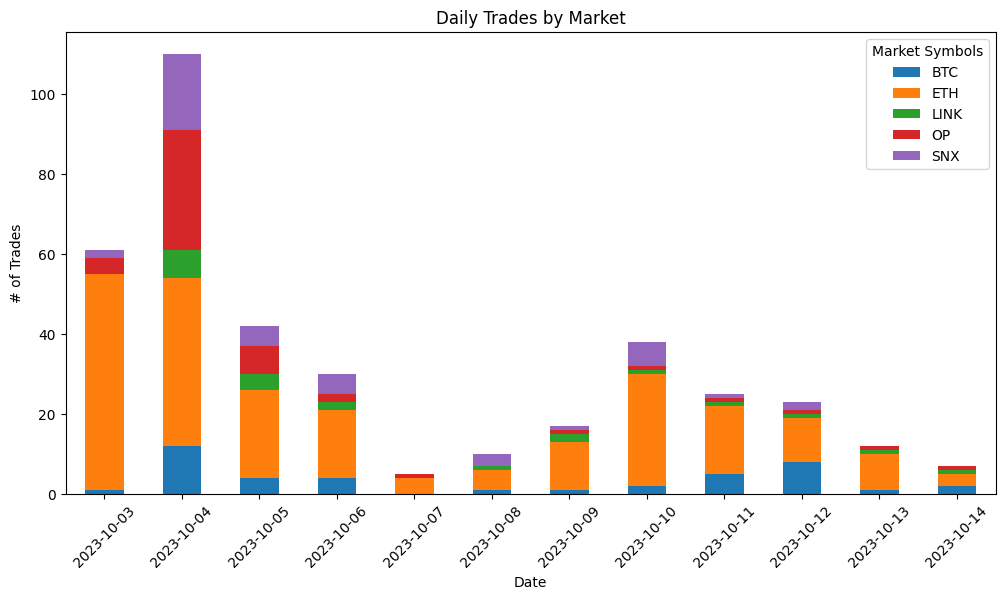

In [9]:
# Pivot the DataFrame to create a stacked bar plot
pivot_df = grouped_df.pivot(index='datetime', columns='markets_marketSymbol', values='count').fillna(0)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
pivot_df.plot(kind='bar', stacked=True, ax=ax)

ax.set_xlabel("Date")
ax.set_ylabel("# of Trades")
ax.set_title("Daily Trades by Market")

# Format the x-axis labels to display only the date
date_format = mdates.DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(date_format)

plt.xticks(range(len(pivot_df.index)), [ts.strftime('%Y-%m-%d') for ts in pivot_df.index], rotation=45)
plt.legend(title="Market Symbols")
plt.show()

In [10]:
preprocessed_df.group_by('markets_marketSymbol').agg([pl.count()]).sort(by='count', descending=True)

markets_marketSymbol,count
str,u32
"""ETH""",224
"""OP""",50
"""SNX""",44
"""BTC""",41
"""LINK""",21


In [11]:
sorted_orders_accts = preprocessed_df.group_by('orderSettleds_accountId').agg([pl.col('size_usd').abs().sum()]).sort(by='size_usd', descending=True)

In [12]:
# largest accounts amount traded 
for row in sorted_orders_accts.rows(named=False):
    print(f"Account: {row[0]:<13} traded ${row[1]:,.2f}")

Account: 215754283.0   traded $149,421,453.98
Account: 2097112578.0  traded $47,126,328.43
Account: 3968420654.0  traded $28,927,481.67
Account: 2993934055.0  traded $22,149,719.07
Account: 1361418361.0  traded $20,895,088.50
Account: 4000498558.0  traded $14,175,988.08
Account: 2251522513.0  traded $12,113,710.71
Account: 3461391369.0  traded $10,513,335.93
Account: 2892008584.0  traded $10,003,824.35
Account: 69.0          traded $9,660,095.22
Account: 3802029150.0  traded $8,633,029.79
Account: 3202664834.0  traded $7,665,160.40
Account: 2557546772.0  traded $6,174,796.77
Account: 2490279701.0  traded $4,779,717.02
Account: 3341266885.0  traded $4,232,431.88
Account: 20790586.0    traded $3,967,477.04
Account: 1315128020.0  traded $3,189,871.82
Account: 89029.0       traded $2,422,549.31
Account: 3215688029.0  traded $2,040,319.23
Account: 2179405963.0  traded $2,003,973.61
Account: 3143303639.0  traded $1,735,454.87
Account: 1407903604.0  traded $1,200,106.03
Account: 91589.0      

In [13]:
market_oi = preprocessed_df.group_by('markets_marketSymbol').agg([pl.col('size_usd').abs().sum()]).sort(by='size_usd', descending=True)

In [14]:
for row in market_oi.rows(named=False):
    print(f"Market: {row[0]:<5}: OI ${row[1]:,.2f}")

Market: ETH  : OI $317,716,736.12
Market: BTC  : OI $39,149,770.92
Market: OP   : OI $12,565,312.55
Market: SNX  : OI $6,420,998.52
Market: LINK : OI $3,111,368.69


In [15]:
total_trading = preprocessed_df.group_by('markets_marketSymbol').agg([pl.col('size_usd').abs().sum()]).sum()['size_usd'].item()

In [16]:
print(f"Total Volume Traded: ${total_trading:,.2f}")

Total Volume Traded: $378,964,186.81
